<a name="начало"></a>

# Titanic

* [Начало](#начало)
* [Стратегия](#strategy)
* [Начална обработка на данните](#processing)
* [Feature engineering](#feature)
    * [Cabin exploration](#cabin)
    * [Deck model](#deck)
    * [Deck model in action](#deck-action)
* [Трениране на модел и submit-ване](#model-submit)
* [Заключение](#conclusion)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mglearn

from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
train = pd.read_csv('data\\train.csv', index_col='PassengerId')

<a name="strategy"></a>

## Стратегия

За да подобря резултата на Стефан ще процедирам по следния начин:
* ще взема на готово всичко, което той е направил
* ще променя това, което не ми харесва в неговата работа
* ще пробвам да почовъркам нещата, които той не засегна

In [3]:
# правим работно копие на train set-a
train_data = train.copy()

<a name="processing"></a>

## Начална обработка

Вземам на готово много разумното хрумване за създаването на колонката Title и попълването на липсващите възрасти чрез нея.

In [4]:
train_data['Title'] = train_data.Name.str.extract('([A-Za-z]+)\.', expand=False)
train_data.loc[train_data.Title == 'Mlle', 'Title'] = 'Miss'
train_data.loc[train_data.Title == 'Mme', 'Title']  = 'Mrs'
train_data.loc[train_data.Title == 'Ms', 'Title']   = 'Miss'

rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Don', 'Jonkheer', 'Capt', 'Lady', 'Sir']
train_data.Title = train_data.Title.replace(rare_titles, 'Rare')

In [5]:
age_by_title = train_data.groupby('Title').Age.mean()
train_data.loc[train_data.Age.isnull() & (train_data.Title == 'Mr'), 'Age'] = age_by_title['Mr']
train_data.loc[train_data.Age.isnull() & (train_data.Title == 'Mrs'), 'Age'] = age_by_title['Mrs']
train_data.loc[train_data.Age.isnull() & (train_data.Title == 'Miss'), 'Age'] = age_by_title['Miss']
train_data.loc[train_data.Age.isnull() & (train_data.Title == 'Master'), 'Age'] = age_by_title['Master']
train_data.loc[train_data.Age.isnull() & (train_data.Title == 'Rare'), 'Age'] = age_by_title['Rare']

Попълвам и двете липсващи Embarked.

In [6]:
train_data.Embarked = train_data.Embarked.fillna('S')

Добавяме FamilySize

In [7]:
train_data['FamilySize'] = train_data['Parch'] + train_data['SibSp'] + 1

От този момент нататък започват някои разминавания м/у моя подход и подхода на Стефан.

Все пак drop-вам колоните Name, Ticket, SibSp и Parch.

In [8]:
train_data = train_data.drop(['Name','Ticket', 'SibSp', 'Parch'], axis=1)

Да видим какво имаме.

In [9]:
train_data.head(10)

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
PassengerId,,,,,,,,,
1,0,3,male,22.00000,7.2500,NaN,S,Mr,2
2,1,1,female,38.00000,71.2833,C85,C,Mrs,2
3,1,3,female,26.00000,7.9250,NaN,S,Miss,1
4,1,1,female,35.00000,53.1000,C123,S,Mrs,2
5,0,3,male,35.00000,8.0500,NaN,S,Mr,1
6,0,3,male,32.36809,8.4583,NaN,Q,Mr,1
7,0,1,male,54.00000,51.8625,E46,S,Mr,1
8,0,3,male,2.00000,21.0750,NaN,S,Master,5
9,1,3,female,27.00000,11.1333,NaN,S,Mrs,3


<a name="feature"></a>

## Feature engineering

Ще махна и колоната Title, защото смятам, че тя свърши своята работа и оттук нататък си мисля, че само би обърквала модела(би трябвало Sex и Age да са достатъчни и дори по-показателни). Остава да реша и как ще процедирам с колонката Cabin. Нея я оставих, защото според мен има значение къде си бил на кораба. Също така ще запазя колоната Fare.

In [10]:
train_data = train_data.drop('Title', axis=1)

<a name="cabin"></a>

## Cabin exploration

Нека започнем разглеждането на Cabin.

In [11]:
train_data.Cabin.describe()

count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object

In [12]:
train_data.Cabin.value_counts()

B96 B98            4
G6                 4
C23 C25 C27        4
F33                3
F2                 3
D                  3
E101               3
C22 C26            3
C123               2
E121               2
C93                2
C125               2
B18                2
C2                 2
B28                2
C124               2
B35                2
D33                2
D20                2
E25                2
B57 B59 B63 B66    2
D36                2
B22                2
B20                2
C83                2
B77                2
C52                2
B58 B60            2
E67                2
B5                 2
                  ..
B30                1
C86                1
B102               1
E46                1
C50                1
C54                1
C103               1
C106               1
C70                1
C104               1
D50                1
E12                1
D37                1
C46                1
D48                1
A20                1
C128         

Виждаме нещо общо. Форматът на всички е главна латинска буква последвана от число. След бърза справка с [интернет](http://www.titanicandco.com/inside.html) виждаме, че буквичката отговаря за това на коя палуба е каютата. Ще я extract-нем в нова колонка.

In [13]:
train_data['Deck'] = train_data.Cabin.str.extract('([A-Z])[0-9]*', expand=False)

In [14]:
train_data.Deck.value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Deck, dtype: int64

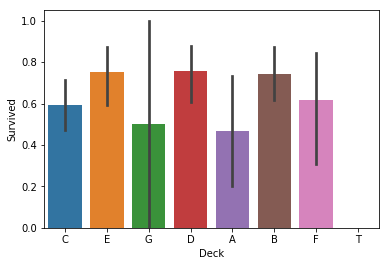

In [15]:
sns.barplot(x='Deck', y='Survived', data=train_data)

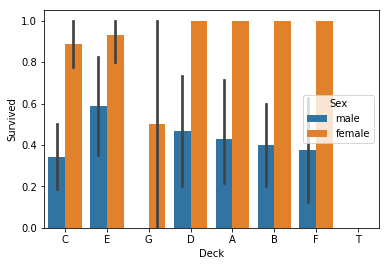

In [16]:
sns.barplot(x='Deck', y='Survived', hue='Sex', data=train_data)

Прогназата се оказа вярна. Хората от Deck F(Upper Deck) имат най-голям шанс да оцелеят, а тези от G(Middle Deck) - най-малък. Естествено записите с попълнен Deck са само 204 и не можем да правим някакви големи заключения, но все пак можем да забележим някои неща. Има само един запис от тип T затова не го вземам под внимание.

Остава обаче да решим как ще попълним останалите.

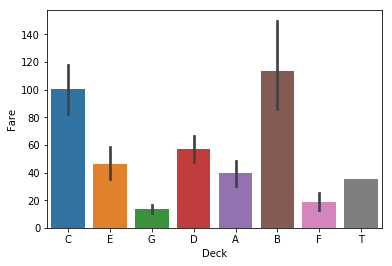

In [17]:
sns.barplot(x='Deck', y='Fare', data=train_data)

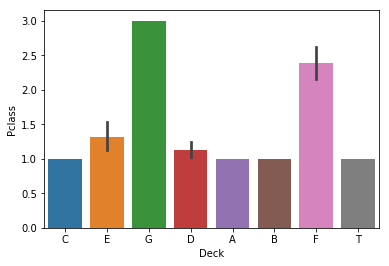

In [18]:
sns.barplot(x='Deck', y='Pclass', data=train_data)

Оказва се, че в Deck G основно са хора с билет за 3-та класа, а и билетите за този Deck са най-евтини. Може би има някаква връзка м/у цена/класа и Deck.

<a name="deck"></a>

## Deck model

Сякаш единственото, което можем да направим е да натренираме модел, който да ни попълни празните Deck записи. Това е малко рисков ход, защото имаме само 204 попълнени записа.

Да видим дали от test set-a няма да можем да намерим още.

Но преди това да encode-нем по селския начин нещата в train set-a. Само ще ги "LabelEncode-на", защото смятам да използвам RF.

In [19]:
train_data['Sex']    = (train_data.Sex == 'male').astype(float) # 1 за мъж, 0 за жена
embarked = {'C': 1, 'Q': 2, 'S': 3}
train_data.Embarked = train_data.Embarked.apply(lambda x:embarked[x])

Махаме и Cabin.

In [20]:
train_data = train_data.drop('Cabin', axis=1)

Да видим какво ще намерим в тест сета.

In [21]:
test = pd.read_csv('data\\test.csv', index_col='PassengerId')

In [22]:
test.Cabin.describe()

count                  91
unique                 76
top       B57 B59 B63 B66
freq                    3
Name: Cabin, dtype: object

Още 91 оттам. Общо 295. Не е зле, би трябвало да се получи нещо чат пат прилично.

Нека опитаме.

Първо прекарваме test set-a през всички трансформации до момента.

In [23]:
test_data = test.copy()
test_data['Title'] = test_data.Name.str.extract('([A-Za-z]+)\.', expand=False)
test_data.loc[test_data.Title == 'Mlle', 'Title'] = 'Miss'
test_data.loc[test_data.Title == 'Mme', 'Title']  = 'Mrs'
test_data.loc[test_data.Title == 'Ms', 'Title']   = 'Miss'

rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Don', 'Jonkheer', 'Capt', 'Lady', 'Sir']
test_data.Title = test_data.Title.replace(rare_titles, 'Rare')

age_by_title = test_data.groupby('Title').Age.mean()
test_data.loc[test_data.Age.isnull() & (test_data.Title == 'Mr'), 'Age'] = age_by_title['Mr']
test_data.loc[test_data.Age.isnull() & (test_data.Title == 'Mrs'), 'Age'] = age_by_title['Mrs']
test_data.loc[test_data.Age.isnull() & (test_data.Title == 'Miss'), 'Age'] = age_by_title['Miss']
test_data.loc[test_data.Age.isnull() & (test_data.Title == 'Master'), 'Age'] = age_by_title['Master']
test_data.loc[test_data.Age.isnull() & (test_data.Title == 'Rare'), 'Age'] = age_by_title['Rare']

test_data.Embarked = test_data.Embarked.fillna('S')
test_data['FamilySize'] = test_data['Parch'] + test_data['SibSp'] + 1
test_data = test_data.drop(['Name','Ticket', 'Title', 'Parch', 'SibSp'], axis=1)

test_data['Sex'] = (test_data.Sex == 'male').astype(float) 
test_data.Embarked = test_data.Embarked.apply(lambda x:embarked[x])

test_data['Deck'] = test_data.Cabin.str.extract('([A-Z])[0-9]*', expand=False)
test_data = test_data.drop('Cabin', axis=1)

In [24]:
test_data.head(10)

,Pclass,Sex,Age,Fare,Embarked,FamilySize,Deck
PassengerId,,,,,,,
892,3,1.0,34.5,7.8292,2,1,NaN
893,3,0.0,47.0,7.0000,3,2,NaN
894,2,1.0,62.0,9.6875,2,1,NaN
895,3,1.0,27.0,8.6625,3,1,NaN
896,3,0.0,22.0,12.2875,3,3,NaN
897,3,1.0,14.0,9.2250,3,1,NaN
898,3,0.0,30.0,7.6292,2,1,NaN
899,2,1.0,26.0,29.0000,3,3,NaN
900,3,0.0,18.0,7.2292,1,1,NaN


И сега да съберем всичко в едно.

In [25]:
train_deck_not_null = train_data.drop('Survived', axis=1)
train_deck_not_null = train_deck_not_null[train_deck_not_null.Deck.notnull()]
test_deck_not_null = test_data[test_data.Deck.notnull()]

In [26]:
print(train_deck_not_null.shape)
print(test_deck_not_null.shape)

(204, 7)
(91, 7)


In [27]:
deck_not_null = pd.concat([train_deck_not_null, test_deck_not_null])

In [28]:
deck_not_null.shape

(295, 7)

In [29]:
deck_not_null.head(10)

,Pclass,Sex,Age,Fare,Embarked,FamilySize,Deck
PassengerId,,,,,,,
2,1,0.0,38.000000,71.2833,1,2,C
4,1,0.0,35.000000,53.1000,3,2,C
7,1,1.0,54.000000,51.8625,3,1,E
11,3,0.0,4.000000,16.7000,3,3,G
12,1,0.0,58.000000,26.5500,3,1,C
22,2,1.0,34.000000,13.0000,3,1,D
24,1,1.0,28.000000,35.5000,3,1,A
28,1,1.0,19.000000,263.0000,3,6,C
32,1,0.0,35.788991,146.5208,1,2,B


Да encode-нем и Deck.

In [30]:
deck_not_null['Deck'] = deck_not_null['Deck'].apply(lambda x: ord(x[0]) - ord('A'))

In [31]:
deck_not_null.Deck.value_counts()

2     94
1     65
3     46
4     41
0     22
5     21
6      5
19     1
Name: Deck, dtype: int64

Да натренираме модел.

In [32]:
X_cabin = deck_not_null.drop('Deck', axis=1)
y_cabin = deck_not_null.Deck

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
rfcl = RandomForestClassifier(n_jobs=2, n_estimators=70)
search = GridSearchCV(rfcl, {"max_depth" : [1, 3, 4, 6, 15, 25, 30],
                             "max_features": [2, 3, 4, 5],
                             "min_samples_leaf" : [1, 2, 4, 6]},
                     cv=KFold(shuffle = True, random_state=1000),
                     n_jobs=2)
search.fit(X_cabin, y_cabin)

pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

,rank_test_score,mean_test_score,params
92,1,0.525424,"{'max_depth': 25, 'max_features': 5, 'min_samp..."
108,2,0.515254,"{'max_depth': 30, 'max_features': 5, 'min_samp..."
76,3,0.505085,"{'max_depth': 15, 'max_features': 5, 'min_samp..."
77,4,0.501695,"{'max_depth': 15, 'max_features': 5, 'min_samp..."
104,4,0.501695,"{'max_depth': 30, 'max_features': 4, 'min_samp..."
109,6,0.494915,"{'max_depth': 30, 'max_features': 5, 'min_samp..."
93,6,0.494915,"{'max_depth': 25, 'max_features': 5, 'min_samp..."
88,8,0.491525,"{'max_depth': 25, 'max_features': 4, 'min_samp..."
72,8,0.491525,"{'max_depth': 15, 'max_features': 4, 'min_samp..."
89,8,0.491525,"{'max_depth': 25, 'max_features': 4, 'min_samp..."


In [34]:
results_frame = pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score')
results_frame.iloc[[0]].params.iloc[0]

{'max_depth': 25, 'max_features': 5, 'min_samples_leaf': 1}

Доооста слабичко..

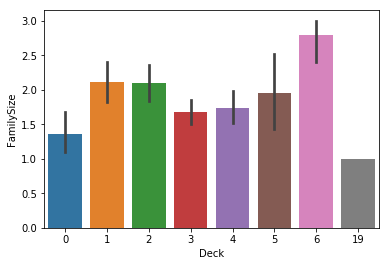

In [35]:
sns.barplot(x='Deck', y='FamilySize',data=deck_not_null)

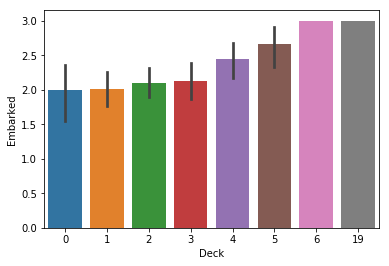

In [36]:
sns.barplot(x='Deck', y='Embarked',data=deck_not_null)

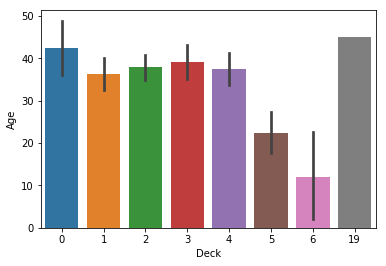

In [37]:
sns.barplot(x='Deck', y='Age',data=deck_not_null)

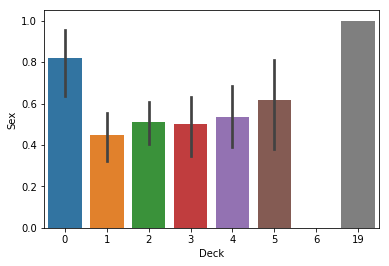

In [38]:
sns.barplot(x='Deck', y='Sex',data=deck_not_null)

Ще махна Embarked и FamilySize и ще пробвам пак.

In [39]:
X_cabin = deck_not_null.drop(['Deck', 'Embarked', 'FamilySize'], axis=1)
y_cabin = deck_not_null.Deck

In [40]:
from sklearn.model_selection import cross_val_score
rfcl = RandomForestClassifier(n_jobs=4, n_estimators=70, max_depth=30, min_samples_leaf = 1)
scores = cross_val_score(rfcl, X_cabin, y_cabin, cv=3, n_jobs=2)
print(scores)
print("Mean: {}".format(scores.mean()))
print("Std:  {}".format(scores.std()))

c:\program files\python\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


[ 0.41176471  0.45918367  0.4       ]
Mean: 0.4236494597839136
Std:  0.025581403829191673


Още по-слабо. Връщам данните както си бяха и пробвам със SVM.

In [42]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
X_cabin = deck_not_null.drop('Deck', axis=1)
y_cabin = deck_not_null.Deck
scaler = StandardScaler().fit(X_cabin)
X_cabin_scaled = scaler.transform(X_cabin)
param_grid = {  "kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
                "gamma" : [1e-1, 1e-2, 1e-3, 1e-4],
                "C" : [1, 10, 100, 1000]}
search = GridSearchCV(SVC(), param_grid=param_grid, cv=KFold(shuffle = True, random_state=1000),n_jobs=2)
search.fit(X_cabin_scaled, y_cabin)

pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

,rank_test_score,mean_test_score,params
17,1,0.423729,"{'C': 10, 'gamma': 0.1, 'kernel': 'poly'}"
2,2,0.413559,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}"
1,3,0.400000,"{'C': 1, 'gamma': 0.1, 'kernel': 'poly'}"
53,3,0.400000,"{'C': 1000, 'gamma': 0.01, 'kernel': 'poly'}"
48,5,0.396610,"{'C': 1000, 'gamma': 0.1, 'kernel': 'linear'}"
60,5,0.396610,"{'C': 1000, 'gamma': 0.0001, 'kernel': 'linear'}"
56,5,0.396610,"{'C': 1000, 'gamma': 0.001, 'kernel': 'linear'}"
52,5,0.396610,"{'C': 1000, 'gamma': 0.01, 'kernel': 'linear'}"
22,5,0.396610,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}"
36,10,0.393220,"{'C': 100, 'gamma': 0.01, 'kernel': 'linear'}"


Явно RF се справя най-добре.

Не получаваме особено добри резултати, но все пак ще използваме RF модел-a, за да си предвидим празните стойности. Може и да не получим нищо хубаво, но си струва да се пробва предвид хвърлените усилия.

In [43]:
rfcl = RandomForestClassifier(n_jobs=4, n_estimators=70, max_depth=25, max_features=5, min_samples_leaf=1)
rfcl.fit(X_cabin, y_cabin)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

<a name="deck-action"></a>

## Deck model in action

Да видим какво ще предвиди модела.

Първо правим малко трансформации на данните, за да са във вид, в който очаква модела.
Ще вземем стойностите с null Deck и ще им премахнем колоните Survived и Deck.

In [44]:
train_deck_null = train_data[train_data.Deck.isnull()]

In [45]:
train_deck_null = train_deck_null.drop('Deck', axis=1)

In [46]:
train_deck_null = train_deck_null.drop('Survived', axis=1)

In [47]:
train_deck_null.head(10)

,Pclass,Sex,Age,Fare,Embarked,FamilySize
PassengerId,,,,,,
1,3,1.0,22.00000,7.2500,3,2
3,3,0.0,26.00000,7.9250,3,1
5,3,1.0,35.00000,8.0500,3,1
6,3,1.0,32.36809,8.4583,2,1
8,3,1.0,2.00000,21.0750,3,5
9,3,0.0,27.00000,11.1333,3,3
10,2,0.0,14.00000,30.0708,1,2
13,3,1.0,20.00000,8.0500,3,1
14,3,1.0,39.00000,31.2750,3,7


Оставяме моделът да предвиди.

In [48]:
train_deck_predicted = pd.DataFrame({
    'PassengerId': train_deck_null.index,
    'Deck': rfcl.predict(train_deck_null)
})

In [49]:
train_deck_predicted = train_deck_predicted.set_index('PassengerId')

Нека да видим какво е предвидил.

In [50]:
train_deck_predicted.Deck.value_counts()

5    480
4     80
3     52
6     38
2     20
1     10
0      7
Name: Deck, dtype: int64

Като цяло може да се каже, че се провалих доста в това начинание и това можеше да се очаква, но все пак ще използвам тези предвиждания и ще видим какво ще стане. Ако е резултатите са слаби, просто ще махнем тази колона.

Сега малко игра с pandas, за да попълним тези предвидени стойности в train set-а.

In [51]:
train_data.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Deck
PassengerId,,,,,,,,
1,0,3,1.0,22.00000,7.2500,3,2,NaN
2,1,1,0.0,38.00000,71.2833,1,2,C
3,1,3,0.0,26.00000,7.9250,3,1,NaN
4,1,1,0.0,35.00000,53.1000,3,2,C
5,0,3,1.0,35.00000,8.0500,3,1,NaN
6,0,3,1.0,32.36809,8.4583,2,1,NaN
7,0,1,1.0,54.00000,51.8625,3,1,E
8,0,3,1.0,2.00000,21.0750,3,5,NaN
9,1,3,0.0,27.00000,11.1333,3,3,NaN


In [52]:
train_data.Deck = train_data.Deck[train_data.Deck.notnull()].apply(lambda x: ord(x[0]) - ord('A'))

In [53]:
train_data = train_data.combine_first(train_deck_predicted)

In [54]:
train_data.head(10)

,Age,Deck,Embarked,FamilySize,Fare,Pclass,Sex,Survived
PassengerId,,,,,,,,
1,22.00000,5.0,3,2,7.2500,3,1.0,0
2,38.00000,2.0,1,2,71.2833,1,0.0,1
3,26.00000,5.0,3,1,7.9250,3,0.0,1
4,35.00000,2.0,3,2,53.1000,1,0.0,1
5,35.00000,5.0,3,1,8.0500,3,1.0,0
6,32.36809,4.0,2,1,8.4583,3,1.0,0
7,54.00000,4.0,3,1,51.8625,1,1.0,0
8,2.00000,5.0,3,5,21.0750,3,1.0,0
9,27.00000,6.0,3,3,11.1333,3,0.0,1


<a name="model-submit"></a>

## Трениране на модел и submit-ване

Нека тренираме модел и да се надяваме, че ще имаме успех.

In [55]:
X, y = train_data.drop('Survived', axis=1), train_data.Survived
model = RandomForestClassifier(n_jobs=2, n_estimators=70)
search = GridSearchCV(model, {"max_depth" : [1, 3, 4, 6, 15, 25, 30],
                             "max_features": [4, 5, 6],
                             "min_samples_leaf" : [1, 2, 4, 6]},
                     cv=KFold(shuffle = True, random_state=1000),
                     n_jobs=2)
search.fit(X, y)

pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

,rank_test_score,mean_test_score,params
55,1,0.826038,"{'max_depth': 15, 'max_features': 5, 'min_samp..."
24,1,0.826038,"{'max_depth': 4, 'max_features': 4, 'min_sampl..."
57,3,0.824916,"{'max_depth': 15, 'max_features': 6, 'min_samp..."
40,4,0.823793,"{'max_depth': 6, 'max_features': 5, 'min_sampl..."
58,5,0.822671,"{'max_depth': 15, 'max_features': 6, 'min_samp..."
44,6,0.821549,"{'max_depth': 6, 'max_features': 6, 'min_sampl..."
18,6,0.821549,"{'max_depth': 3, 'max_features': 5, 'min_sampl..."
75,6,0.821549,"{'max_depth': 30, 'max_features': 4, 'min_samp..."
25,9,0.820426,"{'max_depth': 4, 'max_features': 4, 'min_sampl..."
65,9,0.820426,"{'max_depth': 25, 'max_features': 5, 'min_samp..."


In [56]:
results_frame = pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score')
results_frame.iloc[[0]].params.iloc[0]

{'max_depth': 15, 'max_features': 5, 'min_samples_leaf': 6}

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

model = RandomForestClassifier(n_jobs=2, n_estimators=70, min_samples_leaf=4, max_depth=15, max_features=5)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [66]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.90119760479
0.838565022422


In [67]:
from sklearn.metrics import confusion_matrix
confusion_matrix(model.predict(X_test), y_test)

array([[127,  26],
       [ 10,  60]], dtype=int64)

In [68]:
pd.DataFrame(model.predict_proba(X_test)).head(10)

,0,1
0,0.921210,0.078790
1,0.198224,0.801776
2,0.903984,0.096016
3,0.910175,0.089825
4,0.506295,0.493705
5,0.875237,0.124763
6,0.463546,0.536454
7,0.980354,0.019646
8,0.938376,0.061624
9,0.957571,0.042429


Доста неуверен е моделът, когато казва, че човекът ще оцелее, а и се вижда, че тогава греши повече.

Остава да трансформирам тест сет-а и да събмитна.

In [69]:
test_data.Fare = test_data.Fare.fillna(test_data.Fare.notnull().mean())
test_deck_null = test_data[test_data.Deck.isnull()]
test_deck_null = test_deck_null.drop('Deck', axis=1)
test_deck_predicted = pd.DataFrame({
    'PassengerId': test_deck_null.index,
    'Deck': rfcl.predict(test_deck_null)
})
test_deck_predicted = test_deck_predicted.set_index('PassengerId')
test_data.Deck = test_data.Deck[test_data.Deck.notnull()].apply(lambda x: ord(x[0]) - ord('A'))
test_data = test_data.combine_first(test_deck_predicted)

In [70]:
test_data.head(10)

,Age,Deck,Embarked,FamilySize,Fare,Pclass,Sex
PassengerId,,,,,,,
892,34.5,5.0,2,1,7.8292,3,1.0
893,47.0,5.0,3,2,7.0000,3,0.0
894,62.0,4.0,2,1,9.6875,2,1.0
895,27.0,4.0,3,1,8.6625,3,1.0
896,22.0,6.0,3,3,12.2875,3,0.0
897,14.0,5.0,3,1,9.2250,3,1.0
898,30.0,5.0,2,1,7.6292,3,0.0
899,26.0,5.0,3,3,29.0000,2,1.0
900,18.0,5.0,1,1,7.2292,3,0.0


In [71]:
predictions = model.predict(test_data)
frame = pd.DataFrame({
    'PassengerId': pd.read_csv('data\\test.csv').PassengerId,
    'Survived': predictions
})
frame = frame.set_index('PassengerId')
frame.to_csv('data\\predictions.csv')
frame.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,0


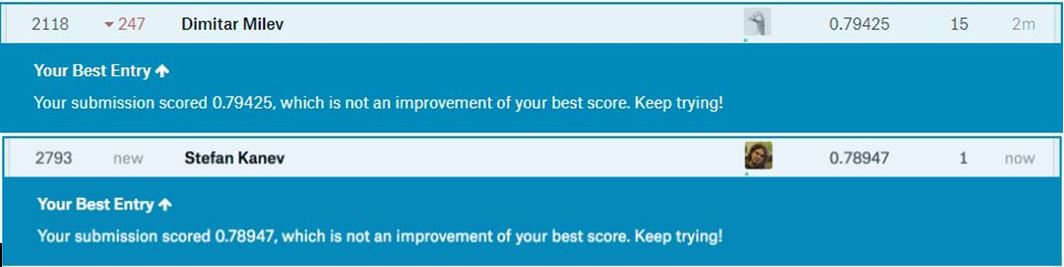

In [72]:
from IPython.display import Image
Image("me_vs_scanf.jpg")

Феноменално.

<a name="conclusion"></a>

# Заключение

За да подобря резултата, трябваше да използвам feature-ите, които не бяха използвани до този момент. Точно това и направих. Моделът, който направих за предвиждането на null стойностите, не беше особено успешен, но и не навреди(даже може би е помогнал), а и беше наистина добро упражнение. Както се вижда, подобрението на резултата е минимално и го постигнах с опитване на различни модели, опитване на неща като категоризиране на feature-ите age и fare, но това което донесе успехът е написаното тук в notebook-а. Най-вероятно има какво още да се изтиска от данните, но аз съм доволен от представянето.

P.S.

Един от предпоследните submit-и ми донесе този резултат, затова във файла predictions.csv не са "печелившите" prediction-и, защото след това пробвах да си подобря още резултата и правих нови prediction-и.